# Auxiliar Functions

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def norm(im):
    """Normaliza una imagen de números reales a [0,1]"""

    return cv2.normalize(im, None, 0.0, 1.0, cv2.NORM_MINMAX)

def read_im(filename, color_flag = 1):
    """Devuelve una imagen de números reales adecuadamente leída en grises o en color.
        - filename: ruta de la imagen.
        - color_flag: indica si es en color (1) o en grises (0)."""

    try:
        im = cv2.imread(filename, color_flag)
        if len(im.shape) == 3:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    except:
        print("Error: no se ha podido cargar la imagen " + filename)
        quit()

    return im.astype(np.double)

def print_im(im, title = "", show = True, tam = (10, 10)):
    """Muestra una imagen cualquiera normalizada.
        - im: imagen a mostrar.
        - show: indica si queremos mostrar la imagen inmediatamente.
        - tam = (width, height): tamaño del plot."""

    show_title = len(title) > 0

    if show:
        fig = plt.figure(figsize = tam)

    im = norm(im)  # Normalizamos a [0,1]
    plt.imshow(im, interpolation = None, cmap = 'gray')
    plt.xticks([]), plt.yticks([])

    if show:
        if show_title:
            plt.title(title)
        plt.show() 

def print_multiple_im(vim, titles = "", ncols = 2, tam = (10, 10)):
    """Muestra una sucesión de imágenes en la misma ventana, eventualmente con sus títulos.
        - vim: sucesión de imágenes a mostrar.
        - titles: o bien vacío o bien una sucesión de títulos del mismo tamaño que vim.
        - ncols: número de columnas del multiplot.
        - tam = (width, height): tamaño del multiplot."""

    show_title = len(titles) > 0

    nrows = len(vim) // ncols + (0 if len(vim) % ncols == 0 else 1)
    plt.figure(figsize = tam)

    for i in range(len(vim)):
        plt.subplot(nrows, ncols, i + 1)
        if show_title:
            plt.title(titles[i])
        print_im(vim[i], title = "", show = False)

    plt.show()

# Tabular data

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = '/content/drive/MyDrive/Nuwe Schneider Hackaton/'
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [ ]:
df_test.head()

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png


# Read images

In [ ]:

def load_images_from_folder(path_list,folder):
    images = []
    files = []
    len=path_list.size
    i=1
    for filename in path_list:
        img = read_im(os.path.join(folder,filename),1)
        img = cv2.resize(img,(224,224))
        files.append(filename)
        if img is not None:
            images.append(img)
        if i == len:
          break
        i += 1
    return images, files


In [ ]:
images_train, images_train_filename = load_images_from_folder(df_train['example_path'],path)

In [ ]:
images_test, images_test_filename = load_images_from_folder(df_test['example_path'],path)

# Data Augmentation


In [ ]:
import tensorflow as tf
import copy

In [ ]:
def preprocessing_one_class(images,df,label, leng):
    # Shift images vertically or horizontally 
    # Fill missing pixels with the color of the nearest pixel
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=.2, 
                                                            height_shift_range=.2,
                                                            vertical_flip=True,
                                                            rotation_range=20,
                                                            fill_mode='reflect')
    
    index_df_label = list(df[df['label']==label].index)
    images_label = [images[i] for i in index_df_label]
    #im_aug_label = np.array(copy.deepcopy(images_label))

    datagen.fit(images_label)
    list_im=next(datagen.flow(np.array(images_label), df[df['label']==label]['label'],batch_size=leng, shuffle=False))
    
    return list_im[0], index_df_label
    

In [ ]:
list_im_1, index_df_1=preprocessing_one_class(images_train,df_train,1,np.sum(df_train.label==1))

In [ ]:
def aniadirListaImagenes(list_im, index_df_label, df, images):
    images_aux=copy.deepcopy(images)
    df_aux=df.copy()
    for i in range(0,len(list_im)):
      df_aux=df_aux.append(df_aux.iloc[[index_df_label[i]]], ignore_index=True)
      images_aux.append(list_im[i])
    return images_aux, df_aux


In [ ]:
imagenes_augmented, df_augmented = aniadirListaImagenes(list_im_1,index_df_1, df_train, images_train)

Vuelvo a meter un batch sobre la clase 1

In [ ]:
list_im_1, index_df_1=preprocessing_one_class(images_train,df_train,1,np.sum(df_train.label==1))
imagenes_augmented, df_augmented = aniadirListaImagenes(list_im_1,index_df_1, df_augmented, imagenes_augmented)

In [ ]:
df_augmented.label.value_counts()

0    860
2    658
1    588
Name: label, dtype: int64

# Preprocessing

In [ ]:

yy_train = []
for i in df_augmented['label']:
  if(i==0):
    yy_train.append([1,0,0])
  elif(i==1):
    yy_train.append([0,1,0])
  else:
    yy_train.append([0,0,1])

yy_train=np.array(yy_train)
yy_train.shape

tabular_train = np.array(df_augmented.loc[:,['latitude','longitude','year']])

In [ ]:
from sklearn.model_selection import train_test_split

idx_train, idx_val, _, _ = train_test_split(np.array(range(len(df_augmented))), df_augmented.label.to_numpy(), test_size=0.33, random_state=42, stratify=df_augmented.label.to_numpy())

In [ ]:
X_train = np.array(imagenes_augmented)[idx_train]
X_val = np.array(imagenes_augmented)[idx_val]
y_train = yy_train[idx_train]
y_val = yy_train[idx_val]
tabular_train=df_augmented.iloc[idx_train][['latitude','longitude']]
tabular_val=df_augmented.iloc[idx_val][['latitude','longitude']]

# Clustering: DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

def clusterizar(locations):
    clustering = DBSCAN(eps=1.5, min_samples=5).fit(locations)
    return clustering
    
locations = np.array([df_augmented.latitude.to_numpy()[idx_train], df_augmented.longitude.to_numpy()[idx_train]]).T
clus = clusterizar(locations)



In [ ]:
print(locations)
print(type(clus.labels_))
print("Num clusters: ", clus.labels_.max())
print(pd.DataFrame(clus.labels_).value_counts())

In [ ]:
print("Número de datos ruidosos (Clúster -1)")
df_augmented.iloc[idx_train][clus.labels_==-1].label.value_counts()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Distancia del conjunto de validación a los datos de entrenamiento
locations_val = np.array([df_augmented.latitude.to_numpy()[idx_val], df_augmented.longitude.to_numpy()[idx_val]]).T
# Calculamos la distancia euclídea entre validación y train
distances = euclidean_distances(locations_val, locations[clus.labels_!=-1])
# Para cada elemento de validación le asignamos el clúster del elemento de train más cercano a él
clus_labels_val = clus.labels_[clus.labels_!=-1][distances.argmin(axis=1)]

In [ ]:
oneHotClusterTrain=np.zeros((tabular_train.shape[0],len(np.unique(clus.labels_))))
oneHotClusterTrain.shape

In [ ]:
for i in range(oneHotClusterTrain.shape[0]):
  oneHotClusterTrain[i][clus.labels_[i]+1]=1

In [ ]:
oneHotClusterTrain

In [ ]:
for i in range(oneHotClusterTrain.shape[1]):
  tabular_train[f'cluster_{i}']=oneHotClusterTrain[:,i]

In [ ]:
tabular_train

In [ ]:
oneHotClusterVal=np.zeros((tabular_val.shape[0],len(np.unique(clus.labels_))))
for i in range(oneHotClusterVal.shape[0]):
  oneHotClusterVal[i][clus_labels_val[i]+1]=1

for i in range(oneHotClusterVal.shape[1]):
  tabular_val[f'cluster_{i}']=oneHotClusterVal[:,i]


In [ ]:
tabular_val

# Normalize

In [ ]:
mean_lat=tabular_train['latitude'].mean()
mean_long=tabular_train['longitude'].mean()

std_lat=tabular_train['latitude'].std()
std_long=tabular_train['longitude'].std()

In [ ]:
tabular_train['latitude']=(tabular_train['latitude']-mean_lat)/std_lat
tabular_train['longitude']=(tabular_train['longitude']-mean_long)/std_long

tabular_val['latitude']=(tabular_val['latitude']-mean_lat)/std_lat
tabular_val['longitude']=(tabular_val['longitude']-mean_long)/std_long

In [ ]:
tabular_val

#Dense Net pretrained

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, concatenate

from keras.optimizers import Adam

from keras import backend as K
#import tensorflow_addons as tfa

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['f1_m']
  val_acc = hist.history['val_f1_m']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=Adam()
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3), pooling='avg')

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))

In [ ]:
carac_val = base_model.predict(datagen_test.flow(X_val,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_val))

# Concat Tabular Info

Here we introduce tabular info and softmax activation layer for multiclass clasification

In [ ]:
import keras

images_input = keras.Input(shape=(1024,), name="images") 
tabular_input = keras.Input(shape=(12,), name="tabular")
#x = BatchNormalization()(tabular_input)
tabular_features = Dense(6, activation = 'relu')(tabular_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
images_features = Dense(512, activation = 'relu')(images_input)
x = concatenate([images_features, tabular_features])
#x = BatchNormalization()(x)
#x = Dense(64, activation = 'relu')(x)
#x = Dense(20, activation = 'relu')(x)
pred = Dense(3, name="priority", activation = 'softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[images_input, tabular_input],
    outputs=[pred],
)

#keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=[f1_m])

results=model.fit({"images": carac_train, "tabular": tabular_train}, y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_split=0.1)
          #callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)])


# evaluamos la red en el conjunto de test
#score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

mostrarEvolucion(results)

In [ ]:
y_predict_saved = model.predict({"images": carac_val, "tabular": tabular_val},verbose=1)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_predict_saved.argmax(axis=1),y_val.argmax(axis=1),average='macro')

In [ ]:
model.summary()

# Final Model

Retrained with all dataset our model and make predictions from test data

In [ ]:
X_train=np.array(imagenes_augmented)
X_test=np.array(images_test)

y_train = []
for i in df_augmented['label']:
  if(i==0):
    y_train.append([1,0,0])
  elif(i==1):
    y_train.append([0,1,0])
  else:
    y_train.append([0,0,1])

y_train=np.array(y_train)


tabular_train = df_augmented[['latitude','longitude']]
tabular_test = df_test[['latitude','longitude']]

In [ ]:
try:
  del imagenes_augmented
except:
  pass

try:
  del images_test
except:
  pass

### Clustering: DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

def clusterizar(locations):
    clustering = DBSCAN(eps=1.5, min_samples=5).fit(locations)
    return clustering
    
locations = np.array([df_augmented.latitude.to_numpy(), df_augmented.longitude.to_numpy()]).T
clus = clusterizar(locations)



In [ ]:
print(locations)
print(type(clus.labels_))
print("Num clusters: ", clus.labels_.max())
print(pd.DataFrame(clus.labels_).value_counts())

[[ -2.05185262 111.82609334]
 [ -1.98934927 105.30949584]
 [  1.22325629 100.7022173 ]
 ...
 [ -2.25188557 114.66411646]
 [ -0.97823086 110.18301897]
 [  0.4433966  112.20016289]]
<class 'numpy.ndarray'>
Num clusters:  10
 1     1028
 0      649
 2      298
 3       30
 4       29
 6       28
 5       11
 8       10
-1        7
 10       6
 7        5
 9        5
dtype: int64


In [ ]:
print("Número de datos ruidosos (Clúster -1)")
df_augmented.iloc[clus.labels_==-1].label.value_counts()

Número de datos ruidosos (Clúster -1)


2    7
Name: label, dtype: int64

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Distancia del conjunto de validación a los datos de entrenamiento
locations_test = np.array([df_test.latitude.to_numpy(), df_test.longitude.to_numpy()]).T
# Calculamos la distancia euclídea entre validación y train
distances = euclidean_distances(locations_test, locations[clus.labels_!=-1])
# Para cada elemento de validación le asignamos el clúster del elemento de train más cercano a él
clus_labels_test = clus.labels_[clus.labels_!=-1][distances.argmin(axis=1)]

In [ ]:
oneHotClusterTrain=np.zeros((tabular_train.shape[0],len(np.unique(clus.labels_))))
oneHotClusterTrain.shape

(2106, 12)

In [ ]:
for i in range(oneHotClusterTrain.shape[0]):
  oneHotClusterTrain[i][clus.labels_[i]+1]=1

In [ ]:
oneHotClusterTrain

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
for i in range(oneHotClusterTrain.shape[1]):
  tabular_train[f'cluster_{i}']=oneHotClusterTrain[:,i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tabular_train

,latitude,longitude,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
0,-2.051853,111.826093,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.989349,105.309496,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.223256,100.702217,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.342948,103.890226,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.126555,101.758175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,-6.500508,138.704721,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2102,-2.950291,133.193605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2103,-2.251886,114.664116,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2104,-0.978231,110.183019,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
oneHotClusterTest=np.zeros((tabular_test.shape[0],len(np.unique(clus.labels_))))
for i in range(oneHotClusterTest.shape[0]):
  oneHotClusterTest[i][clus_labels_test[i]+1]=1

for i in range(oneHotClusterTest.shape[1]):
  tabular_test[f'cluster_{i}']=oneHotClusterTest[:,i]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tabular_test

,latitude,longitude,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
0,0.761681,122.755954,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.059785,113.053791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-2.006610,111.746316,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.901765,114.042495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.911210,100.829633,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,1.650899,101.314723,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631,-1.645649,102.612332,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,-0.557796,114.561609,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
633,-3.037549,113.872045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalize


In [ ]:
mean_lat=tabular_train['latitude'].mean()
mean_long=tabular_train['longitude'].mean()

std_lat=tabular_train['latitude'].std()
std_long=tabular_train['longitude'].std()

In [ ]:
tabular_train['latitude']=(tabular_train['latitude']-mean_lat)/std_lat
tabular_train['longitude']=(tabular_train['longitude']-mean_long)/std_long

tabular_test['latitude']=(tabular_test['latitude']-mean_lat)/std_lat
tabular_test['longitude']=(tabular_test['longitude']-mean_long)/std_long

In [ ]:
tabular_test

,latitude,longitude,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
0,0.629833,1.419614,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.448107,0.390440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.649878,0.251747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.694590,0.495318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.161231,-0.906260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,1.040896,-0.854803,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631,-0.483015,-0.717157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,0.019872,0.550384,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
633,-1.126455,0.477237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Concat model

In [ ]:
from keras.models import Model
from keras.layers import Dense
import keras
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, concatenate

from keras.optimizers import Adam

from keras import backend as K
#import tensorflow_addons as tfa

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['f1_m']
  val_acc = hist.history['val_f1_m']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

opt=Adam()
datagen_train = ImageDataGenerator(preprocessing_function = preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function = preprocess_input)

base_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(224,224,3), pooling='avg')

#obtener la clasificación mediante densenet con imagenet

carac_train  = base_model.predict(datagen_train.flow(X_train,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_train))

2106/2106 [==============================] - 41s 14ms/step


In [ ]:
carac_test = base_model.predict(datagen_test.flow(X_test,batch_size = 1,shuffle = False),
                                    verbose = 1,
                                    steps = len(X_test))

635/635 [==============================] - 9s 14ms/step


Epoch 1/100
15/15 [==============================] - 1s 19ms/step - loss: 0.8582 - f1_m: 0.6097 - val_loss: 1.4159 - val_f1_m: 0.3395
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6187 - f1_m: 0.7385 - val_loss: 0.5737 - val_f1_m: 0.7727
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.5480 - f1_m: 0.7836 - val_loss: 0.5531 - val_f1_m: 0.7789
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4970 - f1_m: 0.8035 - val_loss: 0.3802 - val_f1_m: 0.8474
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4538 - f1_m: 0.8260 - val_loss: 0.5064 - val_f1_m: 0.7891
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4182 - f1_m: 0.8437 - val_loss: 0.3924 - val_f1_m: 0.8493
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.4047 - f1_m: 0.8509 - val_loss: 0.3230 - val_f1_m: 0.8885
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - l

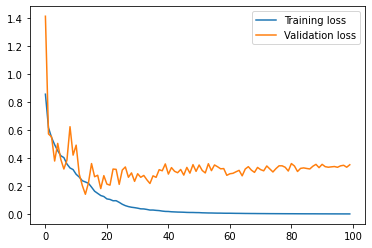

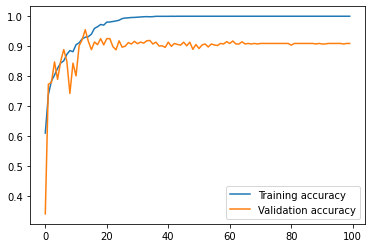

In [ ]:
import keras

images_input = keras.Input(shape=(1024,), name="images") 
tabular_input = keras.Input(shape=(14,), name="tabular")
#x = BatchNormalization()(tabular_input)
tabular_features = Dense(6, activation = 'relu')(tabular_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
images_features = Dense(512, activation = 'relu')(images_input)
x = concatenate([images_features, tabular_features])
#x = BatchNormalization()(x)
#x = Dense(64, activation = 'relu')(x)
#x = Dense(20, activation = 'relu')(x)
pred = Dense(3, name="priority", activation = 'softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[images_input, tabular_input],
    outputs=[pred],
)

#keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=[f1_m])

results=model.fit({"images": carac_train, "tabular": tabular_train}, y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_split=0.1)
          #callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)])


# evaluamos la red en el conjunto de test
#score = basemodel_simple.evaluate(carac_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

mostrarEvolucion(results)

In [ ]:
y_predict_saved = model.predict({"images": carac_test, "tabular": tabular_test},verbose=1)

20/20 [==============================] - 0s 2ms/step


In [ ]:
y_predict_saved

array([[2.1393666e-02, 3.7655484e-02, 9.4095087e-01],
       [1.8436192e-06, 6.9410089e-05, 9.9992871e-01],
       [9.9984682e-01, 1.1510842e-08, 1.5321736e-04],
       ...,
       [6.7199463e-01, 1.5438852e-01, 1.7361681e-01],
       [9.9999988e-01, 1.6575153e-11, 6.1162019e-08],
       [9.9928790e-01, 2.3689948e-04, 4.7517868e-04]], dtype=float32)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 1024)]       0           []                               
                                                                                                  
 tabular (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 512)          524800      ['images[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 6)            90          ['tabular[0][0]']                
                                                                                              

In [ ]:
import json

df_test['target']=y_predict_saved.argmax(axis=1)

df_test

,latitude,longitude,year,example_path,target
0,0.761681,122.755954,2006,train_test_data/test/69.png,2
1,-8.059785,113.053791,2007,train_test_data/test/469.png,2
2,-2.006610,111.746316,2002,train_test_data/test/6.png,0
3,0.901765,114.042495,2016,train_test_data/test/351.png,2
4,1.911210,100.829633,2008,train_test_data/test/1001.png,2
...,...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png,2
631,-1.645649,102.612332,2010,train_test_data/test/54.png,2
632,-0.557796,114.561609,2016,train_test_data/test/494.png,0
633,-3.037549,113.872045,2009,train_test_data/test/287.png,0


In [ ]:
json_str = df_test.target.to_json()

with open(path+'/predictions.json', 'w') as f:
  dic = json.loads(json_str)
  json.dump({'target':dic}, f)